#### TSE, DEFI IA, Baseline.
#### Raphaël Sourty

In [130]:
import os
import pandas as pd
import numpy as np

In [74]:
os.chdir("C:/Defi_IA")

### Load and clean train set:

I chose to rename some columns of the data. These data is a good example of what to avoid. In Python we should always name our columns in lower case and separate the words with an underscore. The variable "station" replaces "number_sta". I'm deliberately getting rid of the date. We won't need it, it is not defined in the test data. The day is now an integer from 0 to 729 (729 for the last day of the second year). I also created a test column that will distinguish test data from training data.

In [75]:
train = pd.read_csv(
    "data/Train/Y_train.csv", 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int, "Ground_truth": float},
).rename(
    columns = {"Ground_truth": "y", "Id": "id", "number_sta": "station"}
).sort_values(["date", "station"]).assign(test=False)

train["month"] = train.date.dt.month.astype(int)
train["day_index"] = train["id"].str.split("_").str[1].astype(int)
train = train.drop("date", axis = "columns")

In [76]:
train.head()

,station,y,id,test,month,day_index
0,14066001,3.4,14066001_0,False,1,0
1,14126001,0.5,14126001_0,False,1,0
2,14137001,3.4,14137001_0,False,1,0
3,14216001,4.0,14216001_0,False,1,0
4,14296001,13.3,14296001_0,False,1,0


### Load and clean test:

I apply the same logic to the test data, my goal being to gather in the same dataframe the test data and the training data in order to calculate the features more easily.

In [175]:
test = pd.read_csv(
    "data/Test/Baselines/Baseline_observation_test.csv",
    dtype = {"Prediction": float}
).assign(test=True).rename(columns = {"Prediction": "y", "Id": "id", "number_sta": "station"})

test["day_index"] = test["id"].str.split("_").str[1].astype(int)

test = pd.merge(
    left = test,
    right = pd.read_csv("data/Test/Id_month_test.csv"),
    on = ["day_index"],
    how = "left",
)

test["station"] = test["id"].str.split("_").str[0].astype(int)

In [78]:
test.shape

(85140, 6)

In [79]:
test.head()

,id,y,test,day_index,month,station
0,14066001_149,None,True,149,1,14066001
1,14126001_149,None,True,149,1,14126001
2,14137001_149,None,True,149,1,14137001
3,14216001_149,None,True,149,1,14216001
4,14296001_149,None,True,149,1,14296001


#### Concat training set and test set:

The training and test data are formatted in the same way, so we can concatenate them. The df dataframe will now be the main dataset. We will add the features to this datafarame `df`. Features are new columns to help us estimate the target variable, we create these features manually. I also choose to delete the `id` column because I can easily find it from the station variable and the day variable.

In [206]:
df = pd.concat([train, test], axis = "rows")
df = df.drop("id", axis = "columns")
df.head()

,station,y,test,month,day_index
0,14066001,3.4,False,1,0
1,14126001,0.5,False,1,0
2,14137001,3.4,False,1,0
3,14216001,4.0,False,1,0
4,14296001,13.3,False,1,0


#### Station latitude, longitude, height

I will add to the df dataframe `df` the latitude and longitude data set.

In [81]:
stations = pd.read_csv(
    "data/Other/stations_coordinates.csv",
    dtype = {"number_sta": int}         
).rename(
    columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"}
)

In [82]:
stations.head()

,station,latitude,longitude,height
0,86118001,46.477,0.985,120.0
1,86149001,46.917,0.025,60.0
2,56081003,48.050,-3.660,165.0
3,53215001,47.790,-0.710,63.0
4,22135001,48.550,-3.380,148.0


In [207]:
df = pd.merge(
    left = df,
    right = stations,
    on = "station",
    how = "left",
)

In [84]:
df.head()

,station,y,test,month,day_index,latitude,longitude,height
0,14066001,3.4,False,1,0,49.334,-0.431,2.0
1,14126001,0.5,False,1,0,49.145,0.042,125.0
2,14137001,3.4,False,1,0,49.180,-0.456,67.0
3,14216001,4.0,False,1,0,48.928,-0.149,155.0
4,14296001,13.3,False,1,0,48.795,-1.037,336.0


In [85]:
df.station.value_counts()

29277001    1092
28239002    1092
37003004    1092
28252002    1092
44069002    1092
            ... 
80248001      16
35238800      13
14047002       9
86118001       3
86149001       3
Name: station, Length: 323, dtype: int64

#### Loading the training features:

The files `data/Test/X_station_test.csv` and `data/Train/X_station_train.csv` contain the available weather stations records with a fine granularity (record per station and per hour). We will use this data to enrich the `df` dataframe that we have previously created. We will have to aggregates those features to add them to our dataframe `df`.

First I will start by loading these data and cleaning them.

In [86]:
train_features = pd.read_csv(
    "data/Train/X_station_train.csv", 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int},
).rename(
    columns = {"number_sta": "station", "Id": "id"}
).assign(test=False)

train_features["month"] = train_features["date"].dt.month.astype(int)
train_features["day_index"] = train_features["id"].str.split("_").str[1].astype(int)
train_features["hour"] = train_features["date"].dt.hour.astype(int)

train_features = train_features.drop(["date", "id"], axis = "columns")

In [87]:
train_features.head()

,station,ff,t,td,hu,dd,precip,test,month,day_index,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,0,0,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,0,0,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,0,0,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,0,0,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,0,0,4


In [88]:
train_features.to_csv("data/Dataset/Train/X_train.csv")

#### Loading the test features:

I apply the same logic to the test features to be able to concatenate all the test and train features. We can then build aggregates and join them to the `df` dataframe.

In [89]:
test_features = pd.read_csv(
    "data/Test/X_station_test.csv", 
).rename(
    columns = {"Id": "id"}
).assign(test=True)

test_features["station"] = test_features["id"].str.split("_").str[0].astype(int)
test_features["day_index"] = test_features["id"].str.split("_").str[1].astype(int)
test_features["hour"] = test_features["id"].str.split("_").str[2].astype(int)

test_features = test_features.drop(["id"], axis = "columns")
test_features.to_csv("data/Dataset/Test/X_test.csv", index=False)

In [208]:
day_index = {day:i for i, day in enumerate(test_features[test_features.station==56137001].day_index.unique())}
df['day'] = np.where(df.test, df.day_index.map(day_index), df.day_index).astype(int)
df.head()

,station,y,test,month,day_index,latitude,longitude,height,day
0,14066001,3.4,False,1,0,49.334,-0.431,2.0,0
1,14126001,0.5,False,1,0,49.145,0.042,125.0,0
2,14137001,3.4,False,1,0,49.180,-0.456,67.0,0
3,14216001,4.0,False,1,0,48.928,-0.149,155.0,0
4,14296001,13.3,False,1,0,48.795,-1.037,336.0,0


#### Features

I now create the `features` dataframe. This dataframe will contain all the records useful for creating features for the `df` data set.

In [179]:
features = pd.concat([train_features, test_features], axis = "rows")

In [102]:
features.head()

,station,ff,t,td,hu,dd,precip,test,month,day_index,day,hour
0,14066001,3.05,279.28,277.97,91.4,200.0,0.0,False,1,0,0,0
1,14066001,2.57,278.76,277.45,91.4,190.0,0.0,False,1,0,0,1
2,14066001,2.26,278.27,277.02,91.7,181.0,0.0,False,1,0,0,2
3,14066001,2.62,277.98,276.95,93.0,159.0,0.0,False,1,0,0,3
4,14066001,2.99,277.32,276.72,95.9,171.0,0.0,False,1,0,0,4


#### New Features

Let's start create new features since we have our two clean dataframes `df` and `features`. Our main objective will be to create aggregates of the `features` dataframe and then perform left-join to the `df` dataframe.

In [92]:
def make_agg(x, on, by, how):
    """Function to make aggregates easilly.
    
    Parameters
    ----------
        x (pd.DataFrame): Features dataframe.
        on (list): List of targets aggregates.
        by (list): List of columns we will use to group data.
        how (list): List of statistics.
    
    """
    columns = []
    for col in on:
        for stat in how:
            columns.append(f"{stat}_{col}") #_by_{'_'.join(by)}")
    x = x.groupby(by)[on].agg(how)  
    x.columns = columns
    return x
    

For example, here is a set of features that might be useful. We compute the mean, sum and standard deviation of variables `["ff", "t", "td", "hu", "dd", "precip"]` grouped by `["station", "day"]`.

In [105]:
make_agg(
    x = features, 
    on = ["ff", "t", "td", "hu", "dd", "precip"], 
    by = ["station", "day_index", "day"],
    how = ["mean"] #, "sum", "std"]
).reset_index()

,station,day_index,day,mean_ff,mean_t,mean_td,mean_hu,mean_dd,mean_precip
0,14047002,31,8,NaN,281.276250,NaN,NaN,NaN,0.000000
1,14047002,39,4,NaN,283.776250,NaN,NaN,NaN,0.337500
2,14047002,100,2,NaN,282.565000,NaN,NaN,NaN,0.412500
3,14047002,223,6,NaN,285.415000,NaN,NaN,NaN,0.033333
4,14047002,236,5,NaN,283.064167,NaN,NaN,NaN,0.291667
...,...,...,...,...,...,...,...,...,...
279797,95690001,725,725,7.699167,279.041667,276.800000,85.587500,202.333333,0.100000
279798,95690001,726,726,8.134167,277.274583,275.160417,86.275000,251.500000,0.133333
279799,95690001,727,727,3.172500,275.019583,273.014583,86.816667,253.583333,0.000000
279800,95690001,728,728,6.341250,277.452500,275.341250,86.637500,211.500000,0.183333


We just have to join these new features with the `pd.merge` method:

In [210]:
agg = make_agg(
    x = features, 
    on = ["ff", "t", "td", "hu", "dd", "precip"], 
    by = ["station", "day_index"],
    how = ["mean"] #, "sum", "std"]
).reset_index()

df_final = pd.merge(
    left = df,
    right = agg,
    on = ["station", "day_index"],
    how = "left",
)

threshold = 0.25
full_na = df_final.groupby("station").agg(
    y_na=("y", lambda x: x.isnull().mean() > threshold),
    ff_na=("mean_ff", lambda x: x.isnull().mean() > threshold),
    t_na=("mean_t", lambda x: x.isnull().mean() > threshold),
    td_na=("mean_td", lambda x: x.isnull().mean() > threshold),
    hu_na=("mean_hu", lambda x: x.isnull().mean() > threshold),
    dd_na=("mean_dd", lambda x: x.isnull().mean() > threshold),
    precip_na=("mean_precip", lambda x: x.isnull().mean() > threshold)
    ).reset_index()
nb_y_na = full_na[full_na.y_na].shape[0]

print(f"{nb_y_na} station removed")

df_final = df_final[(~df_final.station.isin(full_na[full_na.y_na])) | df_final.test]

df_final.y = df_final.y.interpolate()

df_final.to_csv("C:/Defi_IA/data/Dataset/weather.csv", index=False)

28 station removed


In [205]:
df_final.head()

,station,y,test,month,day_index,latitude,longitude,height,day,mean_ff_x,...,mean_td_x,mean_hu_x,mean_dd_x,mean_precip_x,mean_ff_y,mean_t_y,mean_td_y,mean_hu_y,mean_dd_y,mean_precip_y
0,14578001,3.6,False,1,0,49.364,0.167,139.0,0,3.943542,...,277.674167,90.020833,187.812500,0.020833,3.943542,279.330000,277.674167,90.020833,187.812500,0.020833
1,14578001,9.3,False,1,1,49.364,0.167,139.0,1,4.732292,...,283.206458,80.979167,247.041667,0.075000,4.732292,286.750833,283.206458,80.979167,247.041667,0.075000
2,14578001,0.2,False,1,2,49.364,0.167,139.0,2,5.508958,...,279.642708,85.606250,204.541667,0.302083,5.508958,282.073750,279.642708,85.606250,204.541667,0.302083
3,14578001,0.2,False,1,3,49.364,0.167,139.0,3,4.454583,...,281.561875,85.054167,237.375000,0.004167,4.454583,284.076250,281.561875,85.054167,237.375000,0.004167
4,14578001,1.4,False,1,4,49.364,0.167,139.0,4,3.646458,...,282.828542,80.439583,184.333333,0.004167,3.646458,286.461458,282.828542,80.439583,184.333333,0.004167


In [181]:
#Full NA

df_final.groupby("station").agg(
    y_na=("y", lambda x: x.isnull().all()),
    ff_na=("mean_ff", lambda x: x.isnull().all()),
    t_na=("mean_t", lambda x: x.isnull().all()),
    td_na=("mean_td", lambda x: x.isnull().all()),
    hu_na=("mean_hu", lambda x: x.isnull().all()),
    dd_na=("mean_dd", lambda x: x.isnull().all()),
    precip_na=("mean_precip", lambda x: x.isnull().all())
    ).mean()

y_na         0.030960
ff_na        0.501548
t_na         0.021672
td_na        0.436533
hu_na        0.436533
dd_na        0.504644
precip_na    0.030960
dtype: float64

In [193]:
df_final[(df_final.y.isnull()) & (df_final.test == False)].value_counts('station').head(30)

station
29158001    730
14515001    730
29022001    730
28134004    730
50196001    730
44184001    730
29082001    730
28280003    730
50129001    730
29058003    730
29190001    730
29168001    730
41097001    618
78152001    612
45055001    582
50020001    531
22016001    489
79191005    459
56185001    418
35281001    401
28198001    360
62826001    353
72181001    326
62054001    300
28070001    278
53130008    250
29155008    233
44103001    214
86027001    195
36063001    183
dtype: int64

In [188]:
df_final[df_final.test==False]

,station,y,test,month,day_index,latitude,longitude,height,day,mean_ff,mean_t,mean_td,mean_hu,mean_dd,mean_precip
0,14066001,3.4,False,1,0,49.334,-0.431,2.0,0,3.641875,279.904167,278.099167,88.858333,176.625000,0.008333
1,14126001,0.5,False,1,0,49.145,0.042,125.0,0,NaN,279.723958,278.852083,94.302083,NaN,0.020833
2,14137001,3.4,False,1,0,49.180,-0.456,67.0,0,4.416458,279.648125,278.187500,90.820833,170.916667,0.004255
3,14216001,4.0,False,1,0,48.928,-0.149,155.0,0,3.727292,279.662500,277.976250,89.404167,186.125000,0.012500
4,14296001,13.3,False,1,0,48.795,-1.037,336.0,0,NaN,278.587917,NaN,NaN,NaN,0.004167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183742,86137003,5.0,False,12,729,47.035,0.098,96.0,729,4.028333,286.465417,284.495417,88.025000,221.166667,0.141667
183743,86165005,3.2,False,12,729,46.412,0.841,153.0,729,5.950833,285.988333,284.020833,87.887500,239.291667,0.233333
183744,86272002,1.8,False,12,729,46.839,0.457,120.0,729,NaN,286.118750,NaN,NaN,NaN,0.233333
183745,91200002,1.6,False,12,729,48.526,1.993,116.0,729,4.212500,285.455000,284.124167,91.675000,229.708333,0.233333


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

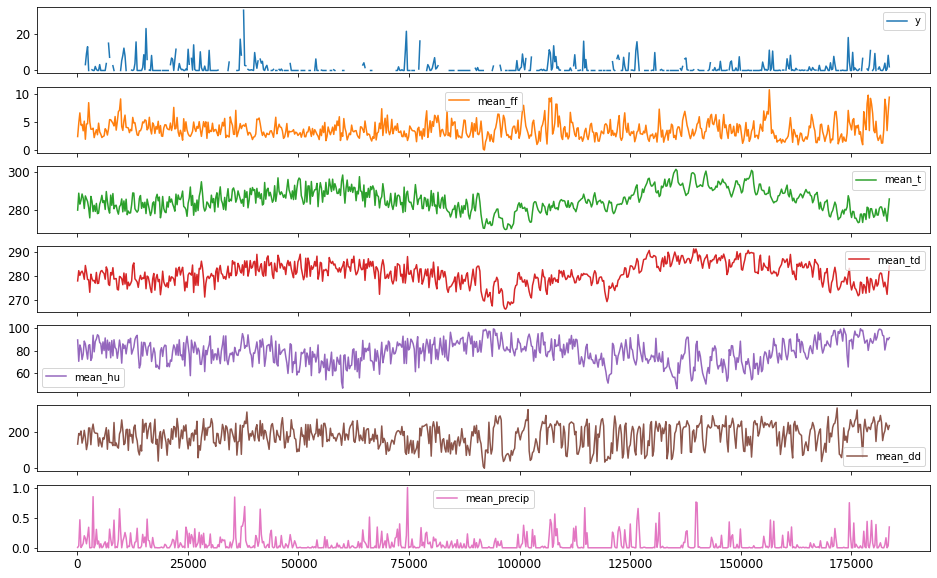

In [194]:
#14066001
#14126001
df_final[(df_final.station==36063001) & (df_final.test==False)].iloc[:730][['y', 'mean_ff', 'mean_t', 'mean_td', 'mean_hu', 'mean_dd', 'mean_precip']].plot(subplots=True, fontsize=12, figsize=(16,10))

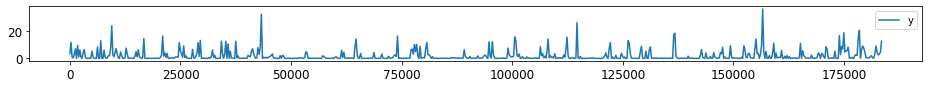

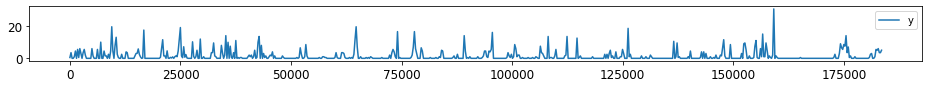

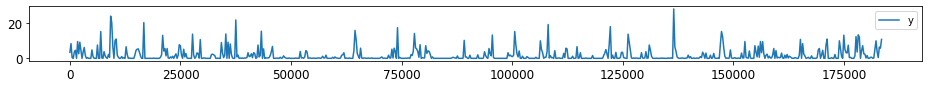

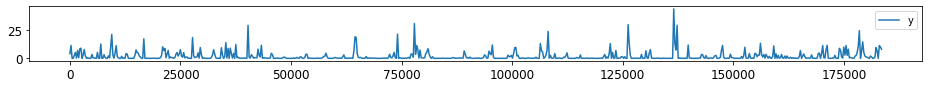

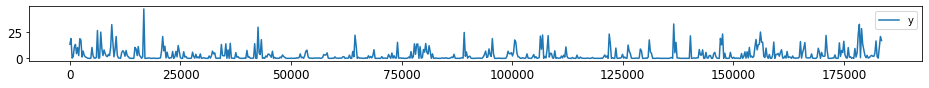

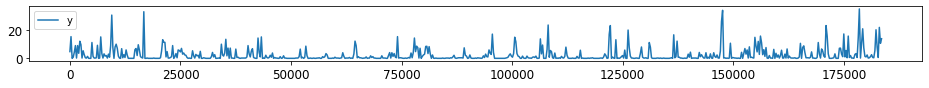

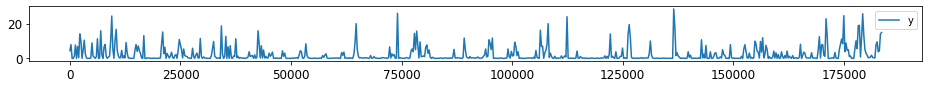

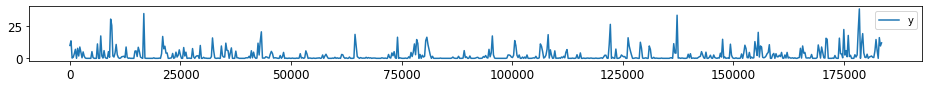

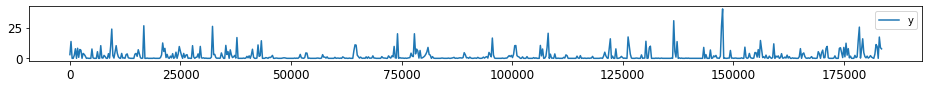

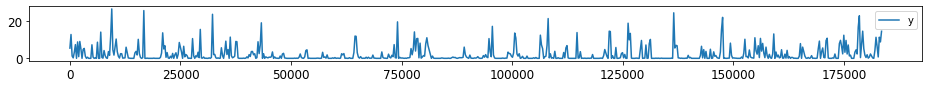

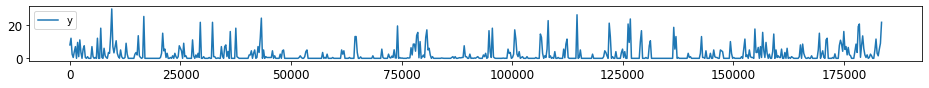

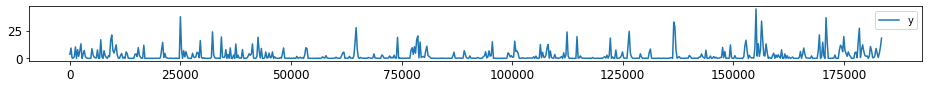

In [211]:
for i, (index, df_iter) in enumerate(df_final[~df_final.test].groupby('station')):
    df_iter[['y']].plot(subplots=True, fontsize=12, figsize=(16, 1))
    if i>10:
        break

<AxesSubplot:>

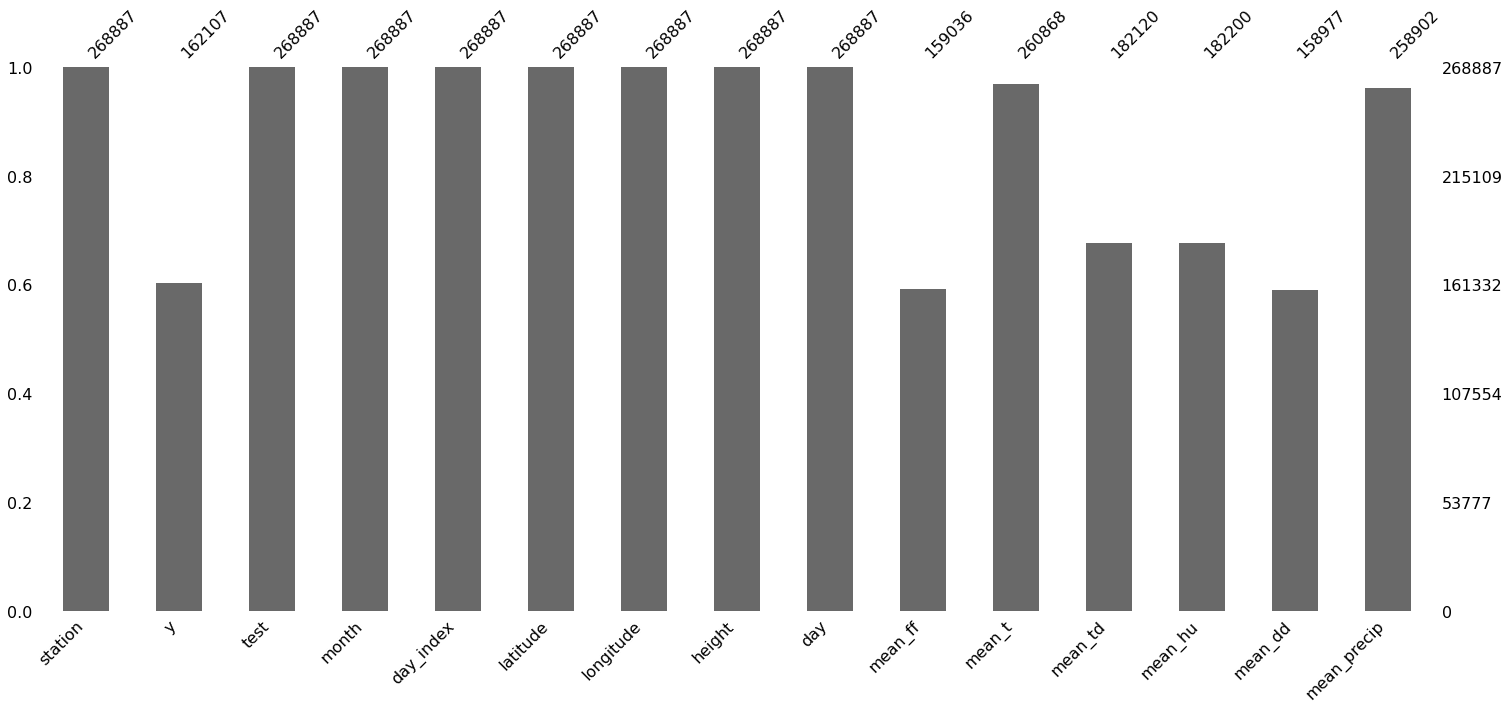

In [158]:
import missingno as msno
msno.bar(df_final)

#### Todo: add features

#### Train test split:

We separate the test game from the training game here to proceed with the model training and inference.

In [97]:
df

,station,y,test,month,day_index,latitude,longitude,height
0,14066001,3.4,False,1,0,49.334,-0.431,2.0
1,14126001,0.5,False,1,0,49.145,0.042,125.0
2,14137001,3.4,False,1,0,49.180,-0.456,67.0
3,14216001,4.0,False,1,0,48.928,-0.149,155.0
4,14296001,13.3,False,1,0,48.795,-1.037,336.0
...,...,...,...,...,...,...,...,...
268882,86137003,None,True,12,293,47.035,0.098,96.0
268883,86165005,None,True,12,293,46.412,0.841,153.0
268884,86273001,None,True,12,293,46.464,1.042,121.0
268885,91200002,None,True,12,293,48.526,1.993,116.0


In [98]:
# The "test" column is a boolean column which is equal to True for test and False for train.
X_train = df[df["test"] == False].copy()
X_test = df[df["test"]].copy()

Some of the samples in the target variable are missing, we will drop it for now but it could be interesting to retrieve them:

In [99]:
X_train = X_train[X_train["y"].notnull()]

# y_train is the target variable to train our model.
y_train = X_train["y"].astype(float).copy()

We re-create the id for the submission and set it as the index of X_test

In [100]:
X_test["id"] = X_test["station"].astype(str) + "_" + X_test["day"].astype(str)
X_test = X_test.set_index("id")

KeyError: 'day'

We will need to drop some columns to avoid errors such as station, test and day and y. 

In [ ]:
columns_to_drop = ["station", "y", "test", "day"]

X_train = X_train.drop(columns_to_drop, axis = "columns")
X_test = X_test.drop(columns_to_drop, axis = "columns")

In [ ]:
X_train.head()

,month,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,sum_t_by_station_day,std_t_by_station_day,...,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
0,1,49.334,-0.431,2.0,3.641875,174.81,1.044607,279.904167,13435.40,2.361743,...,1.229843,88.858333,4265.2,9.340961,176.625000,8478.0,36.306394,0.008333,0.4,0.040388
1,1,49.145,0.042,125.0,NaN,0.00,NaN,279.723958,13426.75,2.153522,...,1.477597,94.302083,4526.5,6.564524,NaN,0.0,NaN,0.020833,1.0,0.100970
2,1,49.180,-0.456,67.0,4.416458,211.99,1.946752,279.648125,13423.11,2.339931,...,1.435294,90.820833,4359.4,8.048971,170.916667,8204.0,35.328750,0.004255,0.2,0.029173
3,1,48.928,-0.149,155.0,3.727292,178.91,1.789319,279.662500,13423.80,1.823406,...,1.215815,89.404167,4291.4,8.507793,186.125000,8934.0,36.127802,0.012500,0.6,0.063998
4,1,48.795,-1.037,336.0,NaN,0.00,NaN,278.587917,13372.22,1.243273,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.004167,0.2,0.028868


In [ ]:
X_test.head()

,month,latitude,longitude,height,mean_ff_by_station_day,sum_ff_by_station_day,std_ff_by_station_day,mean_t_by_station_day,sum_t_by_station_day,std_t_by_station_day,...,std_td_by_station_day,mean_hu_by_station_day,sum_hu_by_station_day,std_hu_by_station_day,mean_dd_by_station_day,sum_dd_by_station_day,std_dd_by_station_day,mean_precip_by_station_day,sum_precip_by_station_day,std_precip_by_station_day
id,,,,,,,,,,,,,,,,,,,,,
14066001_149,1,49.334,-0.431,2.0,5.111875,245.37,1.379676,284.672292,13664.27,2.853501,...,3.137449,84.187500,4041.0,5.007255,195.166667,9368.0,104.800181,0.029167,1.4,0.202073
14126001_149,1,49.145,0.042,125.0,NaN,0.00,NaN,283.686458,13616.95,2.972547,...,3.320618,94.531250,4537.5,3.839058,NaN,0.0,NaN,0.093750,4.5,0.352140
14137001_149,1,49.180,-0.456,67.0,4.645417,222.98,1.701881,283.993750,13631.70,3.215890,...,3.333271,85.450000,4101.6,6.475781,241.145833,11575.0,70.503656,0.008333,0.4,0.057735
14216001_149,1,48.928,-0.149,155.0,3.275208,157.21,1.082365,283.404583,13603.42,2.897035,...,3.680259,88.864583,4265.5,8.111339,272.520833,13081.0,69.952260,0.104167,5.0,0.430714
14296001_149,1,48.795,-1.037,336.0,NaN,0.00,NaN,282.623542,13565.93,3.346850,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.075000,3.6,0.390581


#### Handle missing values:

I choose to replace the missing values by -1, there are surely better solutions to replace the missing values.

In [ ]:
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

#### Cross-validation

I choose here to use the LightGbm model. It is a very powerful model that wins most of the machine learning competitions. It is interesting because we can use it to measure the weight of features in the decision making of the model. Moreover, the Lightgbm API is quite practical. It is important to look for the best model parameters.

In the framework of the tutorials we will use many other models. The winning solution of the DEFI AI contest will be built from a set of models. We will come back to this later.

Documentation to install LightGBM: [lightgbm](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html).

In [ ]:
import lightgbm as lgbm

from sklearn import model_selection
from sklearn import metrics

#  Fold:
k = 5

cv = model_selection.KFold(k, shuffle=True, random_state=42)

model = lgbm.LGBMRegressor(
    n_estimators=600, # Number of trees
    objective="l2",
    random_state=42,
)

error_validation = 0

sub = pd.Series(0.0, index=X_test.index)

for fit_idx, val_idx in cv.split(X_train, y_train):

    X_fit = X_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    
    y_fit = y_train.iloc[fit_idx] 
    y_val = y_train.iloc[val_idx]

    model.fit(
        X_fit,
        y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=("fit", "val"),
        eval_metric="l2",
        early_stopping_rounds = 200,
        feature_name=X_fit.columns.tolist(),
        verbose=50,
    )
    
    # Validation predictions:
    error_validation += metrics.mean_absolute_percentage_error(
        y_true = model.predict(X_val) + 1, 
        y_pred = y_val + 1,
    ) / k
    
    # Bagging
    # Since we train 5 models using cross-validation with k=5 folds, we average the prediction of each models.
    # It helps a lot!
    sub += model.predict(X_test) / k
    
# To avoid zero-division errors, METEO FRANCE added 1 to the target variable, so we do it too.
sub += 1

C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 13.1081	val's l2: 13.8932
[100]	fit's l2: 12.0356	val's l2: 13.2353
[150]	fit's l2: 11.2938	val's l2: 12.7932
[200]	fit's l2: 10.6701	val's l2: 12.4717
[250]	fit's l2: 10.1817	val's l2: 12.2075
[300]	fit's l2: 9.76531	val's l2: 11.9753
[350]	fit's l2: 9.37867	val's l2: 11.7788
[400]	fit's l2: 9.06302	val's l2: 11.6357
[450]	fit's l2: 8.7873	val's l2: 11.5235
[500]	fit's l2: 8.59375	val's l2: 11.458
[550]	fit's l2: 8.31881	val's l2: 11.3564
[600]	fit's l2: 8.12566	val's l2: 11.288
[650]	fit's l2: 7.94948	val's l2: 11.235
[700]	fit's l2: 7.73237	val's l2: 11.1574
[750]	fit's l2: 7.52439	val's l2: 11.0876
[800]	fit's l2: 7.338	val's l2: 11.0259
[850]	fit's l2: 7.16714	val's l2: 10.9753
[900]	fit's l2: 7.01213	val's l2: 10.9373
[950]	fit's l2: 6.83905	val's l2: 10.8764
[1000]	fit's l2: 6.6971	val's l2: 10.8343


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 13.1144	val's l2: 13.9811
[100]	fit's l2: 11.9992	val's l2: 13.2613
[150]	fit's l2: 11.2322	val's l2: 12.8223
[200]	fit's l2: 10.6322	val's l2: 12.5282
[250]	fit's l2: 10.1281	val's l2: 12.3179
[300]	fit's l2: 9.6609	val's l2: 12.105
[350]	fit's l2: 9.33854	val's l2: 11.9959
[400]	fit's l2: 9.02078	val's l2: 11.8701
[450]	fit's l2: 8.72993	val's l2: 11.7625
[500]	fit's l2: 8.45551	val's l2: 11.6693
[550]	fit's l2: 8.20403	val's l2: 11.5825
[600]	fit's l2: 7.97343	val's l2: 11.5256
[650]	fit's l2: 7.80085	val's l2: 11.4952
[700]	fit's l2: 7.60437	val's l2: 11.4406
[750]	fit's l2: 7.38972	val's l2: 11.3798
[800]	fit's l2: 7.2137	val's l2: 11.3267
[850]	fit's l2: 7.04926	val's l2: 11.2788
[900]	fit's l2: 6.90361	val's l2: 11.2433
[950]	fit's l2: 6.74726	val's l2: 11.2074
[1000]	fit's l2: 6.61713	val's l2: 11.1813


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 13.1588	val's l2: 13.6837
[100]	fit's l2: 12.066	val's l2: 13.043
[150]	fit's l2: 11.3088	val's l2: 12.6318
[200]	fit's l2: 10.7066	val's l2: 12.3099
[250]	fit's l2: 10.2423	val's l2: 12.0784
[300]	fit's l2: 9.85112	val's l2: 11.8926
[350]	fit's l2: 9.48095	val's l2: 11.7354
[400]	fit's l2: 9.13802	val's l2: 11.6169
[450]	fit's l2: 8.84705	val's l2: 11.511
[500]	fit's l2: 8.56304	val's l2: 11.3819
[550]	fit's l2: 8.29637	val's l2: 11.2826
[600]	fit's l2: 8.08343	val's l2: 11.2155
[650]	fit's l2: 7.86582	val's l2: 11.1515
[700]	fit's l2: 7.66861	val's l2: 11.0917
[750]	fit's l2: 7.47634	val's l2: 11.0221
[800]	fit's l2: 7.31915	val's l2: 10.9791
[850]	fit's l2: 7.16783	val's l2: 10.9355
[900]	fit's l2: 7.00752	val's l2: 10.8924
[950]	fit's l2: 6.85748	val's l2: 10.8579
[1000]	fit's l2: 6.6931	val's l2: 10.797


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 13.1448	val's l2: 13.8073
[100]	fit's l2: 12.0064	val's l2: 13.0431
[150]	fit's l2: 11.2867	val's l2: 12.6589
[200]	fit's l2: 10.7532	val's l2: 12.3691
[250]	fit's l2: 10.2552	val's l2: 12.1106
[300]	fit's l2: 9.84472	val's l2: 11.9096
[350]	fit's l2: 9.46795	val's l2: 11.7295
[400]	fit's l2: 9.15379	val's l2: 11.5731
[450]	fit's l2: 8.85653	val's l2: 11.4753
[500]	fit's l2: 8.60248	val's l2: 11.3725
[550]	fit's l2: 8.34115	val's l2: 11.2803
[600]	fit's l2: 8.11344	val's l2: 11.1943
[650]	fit's l2: 7.90816	val's l2: 11.1107
[700]	fit's l2: 7.72632	val's l2: 11.0538
[750]	fit's l2: 7.54452	val's l2: 10.9945
[800]	fit's l2: 7.36513	val's l2: 10.9394
[850]	fit's l2: 7.20446	val's l2: 10.9023
[900]	fit's l2: 7.02598	val's l2: 10.8456
[950]	fit's l2: 6.86957	val's l2: 10.7976
[1000]	fit's l2: 6.71706	val's l2: 10.7567


C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mathi\anaconda3\envs\defi_ia_2022\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	fit's l2: 13.2422	val's l2: 13.3691
[100]	fit's l2: 12.1725	val's l2: 12.6824
[150]	fit's l2: 11.4243	val's l2: 12.2675
[200]	fit's l2: 10.8224	val's l2: 11.9465
[250]	fit's l2: 10.3241	val's l2: 11.6974
[300]	fit's l2: 9.92379	val's l2: 11.51
[350]	fit's l2: 9.54616	val's l2: 11.3344
[400]	fit's l2: 9.19854	val's l2: 11.1778
[450]	fit's l2: 8.88828	val's l2: 11.0414
[500]	fit's l2: 8.59707	val's l2: 10.8954
[550]	fit's l2: 8.3434	val's l2: 10.7959
[600]	fit's l2: 8.12567	val's l2: 10.719
[650]	fit's l2: 7.93488	val's l2: 10.6707
[700]	fit's l2: 7.76633	val's l2: 10.6297
[750]	fit's l2: 7.56994	val's l2: 10.5593
[800]	fit's l2: 7.39196	val's l2: 10.5064
[850]	fit's l2: 7.23717	val's l2: 10.4663
[900]	fit's l2: 7.07985	val's l2: 10.413
[950]	fit's l2: 6.941	val's l2: 10.3809
[1000]	fit's l2: 6.81149	val's l2: 10.3579


#### Your main goal is to reduce the value of this metric, i.e. make fewer errors. If you create a feature that does not reduce MAPE then you can throw it away. For each feature you create, you should re-execute the notebook and verify that the feature helps. The order in which you create the features does not matter. You should start by building the simplest features.

In [ ]:
print(f"MAPE on validation set: {error_validation}")

MAPE on validation set: 0.7504970970859937


#### Weight of our features

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

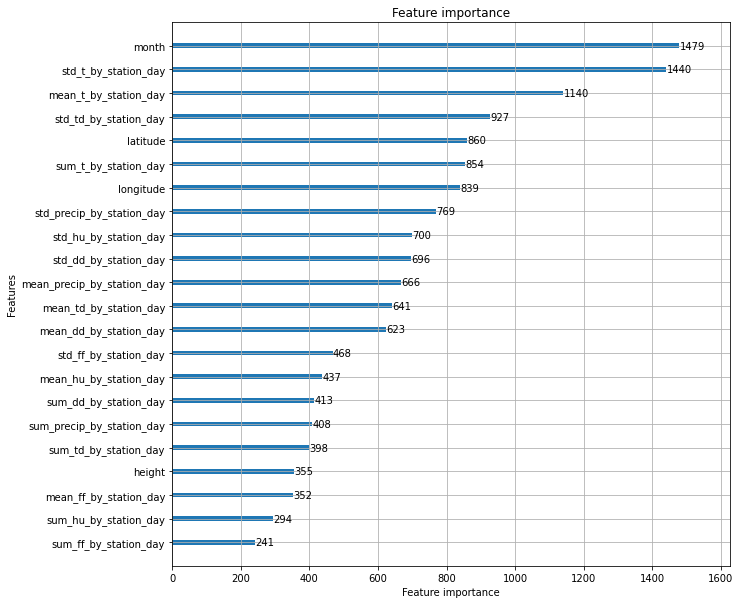

In [ ]:
lgbm.plot_importance(model._Booster, figsize=(10, 10))

#### Our submission:

In [ ]:
sub = sub.rename("Prediction").reset_index().rename(columns = {"id": "Id"})

In [ ]:
sub.to_csv("submission.csv", index=False)
sub

,Id,Prediction
0,14066001_149,3.321204
1,14126001_149,2.732741
2,14137001_149,2.716594
3,14216001_149,2.429709
4,14296001_149,6.094926
...,...,...
85135,86137003_293,0.997174
85136,86165005_293,1.074055
85137,86273001_293,2.752452
85138,91200002_293,0.771007


#### How to improve this notebook:

- Create a lots of features that reduce the MAPE
- Handle missing values
- Handle outliers, i.e extreme values
- Tune the hyperparameters of your model
- Create multiples models (Blending / Stacking)

- Predict the error rather that the target variable directly, [METEO FRANCE MODELS LINK, available soon](https://meteonet.umr-cnrm.fr/dataset/data/defi_ia_challenge/).


#### Useful resources:

https://maxhalford.github.io/blog/target-encoding/

https://explained.ai/gradient-boosting/